<a href="https://colab.research.google.com/github/delalamo/dda_docs/blob/main/DEERNet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.stats import skewnorm, cauchy, t

We will first need to define a few constants for our functions. These include then minima, maxima, and scaling factors dictating whether values tend to be bunched to lower or higher values (high scaling factors lead to bunching at lower values).

In [4]:
MEAN_LO = 15.
MEAN_HI = 70.
MEAN_SCALE = 4

STDEV_LO = 0.5
STDEV_HI = 15.
STDEV_SCALE = 10

SKEW_LO = 0.
SKEW_HI = 10.
SKEW_SCALE = 4

DIST_MIN = 10.
DIST_MAX = 80.
DIST_STEP = 0.1

In [5]:
def gauss( u, s, amp, skew=0, df=0, rmin=10., rmax=80., step=0.1 ):
	return np.array( [ amp * skewnorm.pdf( ( r - u ) / s, skew )
		for r in np.arange( rmin, rmax, step ) ] )

def lorentzian( u, s, amp, skew=0, df=0, rmin=10., rmax=80., step=0.1 ):
	return np.array( [ amp * cauchy.pdf( ( r - u ) / s )
		for r in np.arange( rmin, rmax, step ) ] )

def t_dist( u, s, amp, skew=0, df=1, rmin=10., rmax=80., step=0.1 ):
	return np.array( [ amp * t.pdf( ( r - u ) / s, df )
		for r in np.arange( rmin, rmax, step ) ] )

def rand_distr( rmin=10., rmax=80., step=0.1, nmin=1, nmax=3 ):
  output = np.zeros( ( len( np.arange( rmin, rmax, step ) ) ) )
  n = np.random.uniform( 0.1, 1.0, random.randint( 1, 3 ) )
  n /= n.sum()
  for amp in n:
    fxn = random.choice( [ gauss, lorentzian, t_dist ] )
    output += fxn(
        u=np.random.uniform(
            low=MEAN_LO**(1./MEAN_SCALE),
            high=MEAN_HI**(1./MEAN_SCALE) )**MEAN_SCALE,
        s=np.random.uniform(
            low=STDEV_LO**(1./STDEV_SCALE),
            high=STDEV_HI**(1./STDEV_SCALE) )**STDEV_SCALE,
        amp=amp,
        skew=random.choice( range( -1, 2 ) ) *
          np.random.uniform(
              low=SKEW_LO**(1./SKEW_SCALE),
              high=SKEW_HI**(1./SKEW_SCALE) ) ** SKEW_SCALE,
        df=random.randint( 1, 10 ),
        rmin=DIST_MIN,
        rmax=DIST_MAX,
        step=DIST_STEP
    )
  return output / sum( output )


Here are a few examples of these distance data

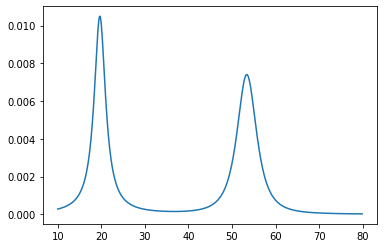

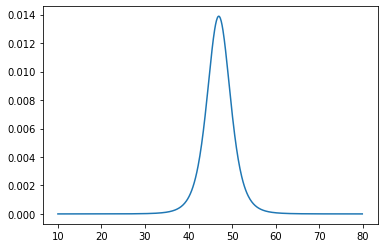

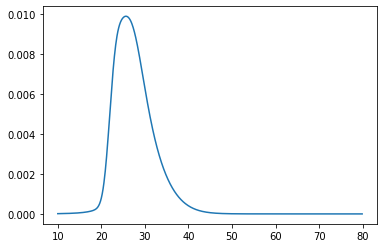

In [15]:
for i in range( 3 ):
  distr = rand_distr()
  plt.plot( np.arange( DIST_MIN, DIST_MAX, DIST_STEP ), distr )
  plt.show()

Next we need to convert these data into DEER traces in the time domain. First we simulate the signal from the distance data, then we add in the background DEER signal.

In [7]:
angle_bins = np.arange( 0., np.pi / 2., 0.02) )
deer_bins = 1. -3. * ( np.cos( angle_bins ) ** 2 )

def dipolar_kernel( rd, tp ):
  if rd < 15.: # HARD CUTOFF DUE TO DIPOLAR J-COUPLING
    return 0.0
  vc = np.zeros( len( deer_bins ) ) + ( 326.98 * tp / ( ( rd / 10. ) ** 3. ) )
  vc = np.sin( angle_bins ) * np.cos( vc * deer_bins )
  return np.sum( vc )

In [8]:
def convert_to_decay( distr, time_pts, dist_bins ):
  output = torch.zeros( len( time_pts ) )
  for i, tp in enumerate( time_pts ):
    for amp, rd in zip( distr, np.arange( DIST_MIN, DIST_MAX, DIST_STEP ) ):
      output[ i ] += amp * dipolar_kernel( rd, tp )
  return output / output.max()

Let's test out some of these functions really quickly.

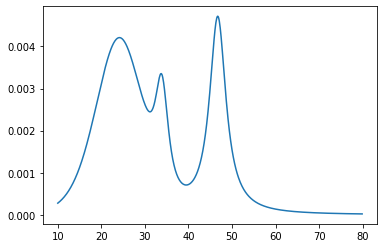

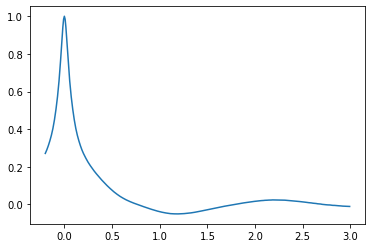

In [22]:
bins = np.arange( 10., 80., 0.1 )
distr = rand_distr()
plt.plot( bins , distr )
plt.show()

time_pts = torch.Tensor( np.arange( -0.2, 3.0, 0.008 ) )
trace = convert_to_decay( distr, time_pts, bins )
plt.plot( time_pts, trace )
plt.show()

Looks pretty good. Now let us add the background component and a little bit of Gaussian noise.

In [10]:
def to_intra( tr, tp, d, k, l ):
  return torch.exp((torch.abs(tp)*k)**(d/3.))*(1.-l*(1.-tr))

def add_bckg( trace, time_pts ):
  d = 3. + np.random.uniform( -1., 0.5 ) * random.choice( [ 0., 1. ] )
  k = np.random.uniform( -10 ** -6., -10 ** -0.5 )
  l = np.random.uniform( 0.05, 0.7 )
  return np.array( [ to_intra( tr, tp, d, k, l ) for tr, tp in zip( trace, time_pts ) ] )

def add_noise( trace ):
  n = np.random.uniform( 0.005**(1./5.), 0.1**(1./5.) )**5.
  return trace + torch.Tensor( np.random.normal( 0., n, len( trace ) ) )

def normalize( trace ):
  return trace / max( trace )

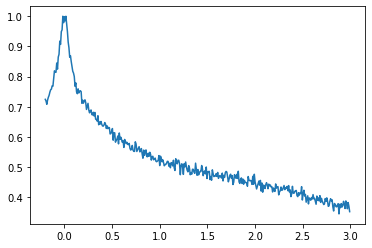

In [26]:
noisy_trace = normalize( add_noise( add_bckg( trace, time_pts ) ) )
plt.plot( time_pts, noisy_trace )
plt.show()

Unfortunately, since the process for simulating DEER decay traces from distance data takes so long, I went ahead and wrote a small program in C++ that does this. All distance data are simulated here and converted to decay traces in that program. The distance data will be the "target" and the decay data will be the input.

In [58]:
n_distrs = 10
df = pd.DataFrame()
for i in range( n_distrs ):
  print( i )
  distr = rand_distr()
  df2 = pd.DataFrame( distr.reshape( -1, len( distr ) ) )
  df = pd.concat( [ df, df2 ] )
print( df.shape )
df.to_csv( "distributions.csv" )

0
1
2
3
4
5
6
7
8
9
(10, 700)
